<a target="_blank" href="https://colab.research.google.com/github/avakanski/Fall-2022-Python-Programming-for-Data-Science/blob/main/Lectures/Theme%204%20-%20Model%20Deployment%20Pipelines/Lecture%2029%20-%20Monitoring%20Performance/Lecture%2029%20-%20Monitoring%20Performance.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a name='section0'></a>
# Lecture 29 Monitoring Project Performance, Data Distribution Shifts

- [29.1 Introduction](#section1)
- [29.2 Monitoring Performance Metrics](#section2)
- [29.3 Data Validation](#section3)
- [29.4 Data Distribution Shift](#section4)
    - [29.4.1 Measuring Drift in Univariate Numerical Data](#section4-1)
    - [29.4.2 Measuring Drift in Univariate Categorical Data](#section4-2)
    - [29.4.3 Measuring Drift in Multivariate Data](#section4-3)
- [29.5 Monitoring Drift in Online Data](#section5) 
- [29.6 Data Outliers](#section6)    
- [29.7 Taking Actions](#section7) 
- [References](#section8)

<a name='section1'></a>

# 29.1 Introduction

Monitoring the performance of deployed Data Science projects is important, because the performance of deployed models often decreases after certain period of time in production. There can be many reasons for performance degradation, ranging from bugs in the data and model pipelines, to shifts in the data distribution, or adversarial attacks on the model. Deployed systems should be provided with functions for monitoring the performance, measuring and identifying performance degradation, informing the team members of the performance, triggering actions, etc.

This lecture focuses on identifying and measuring performance degradation. The lecture was developed based on the blog [Made with ML / Monitoring](https://madewithml.com/courses/mlops/monitoring/). 

<a name='section2'></a>

# 29.2 Monitoring Performance Metrics

Monitoring the system performance includes tracking performance metrics, such as accuracy, recall, precision, f1-score, AUC-ROC, or  other metrics. As well as, it can include monitoring business metrics, such as customers' click rate, purchase amounts, product demand, or similar.

Furthermore, monitoring the performance based only on the current value of the adopted metrics may not be productive, due to variance in the values. Monitoring needs to include cumulative and sliding window values of the metrics over a period of time. In addition, different periods of time may need to be considered, since for instance, a metric of the average performance of the system in the last day or week may be preferred over a metric that calculates the average performance of the system in the last 3 months. 

An example is presented next, where the hourly accuracy of a Machine Learning model is adopted as a metric for monitoring system performance. The used data in this example is synthetic, and not an actual accuracy of a real process, and that is why the randomness of the data looks well controlled. The values of the accuracy for 840 hours are plotted below. It is noticeable that the performance of the model degraded over time, where initially the accuracy was over 95%, but it decreased to below 90%.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
cd 'drive/MyDrive/Data_Science_Course/Lecture_29-Monitoring_Performance/data/'

/content/drive/MyDrive/Data_Science_Course/Lecture_29-Monitoring_Performance/data


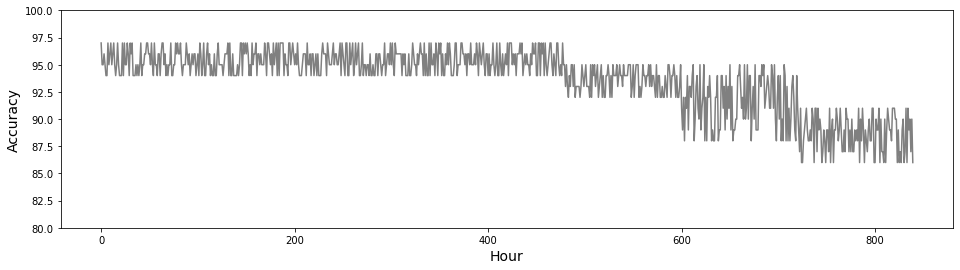

In [4]:
# load the performance data
hourly_accuracy = np.load("hourly_accuracy.npy")

# plot the performance data
plt.figure(figsize=(16,4))
plt.ylim([80, 100])
plt.plot(hourly_accuracy, color='gray')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Hour', fontsize=14)
plt.show()

### Average Cumulative Accuracy

A common metric for performance monitoring is the average cumulative accuracy of the available data. This metric smooths the data, by applying averaging over all data points. The plot for the accuracy is shown below, where the value of the metric in the last 24 hours is equal to 93.7% accuracy. 

In [5]:
# array length 
print('Number of observations:', np.size(hourly_accuracy))

Number of observations: 840


In [6]:
# calcuate cumulative accuracy
cumulative_accuracy = np.zeros((840,))
for n in range(1, np.size(hourly_accuracy)):
    cumulative_accuracy[n] = np.mean(hourly_accuracy[:n])

# print average daily cumulative accuracy in the last 24 hours
print (f"Average cumulative accuracy in the last 24 hours: {np.mean(cumulative_accuracy[-24:]):.1f}")

Average cumulative accuracy in the last 24 hours: 93.7


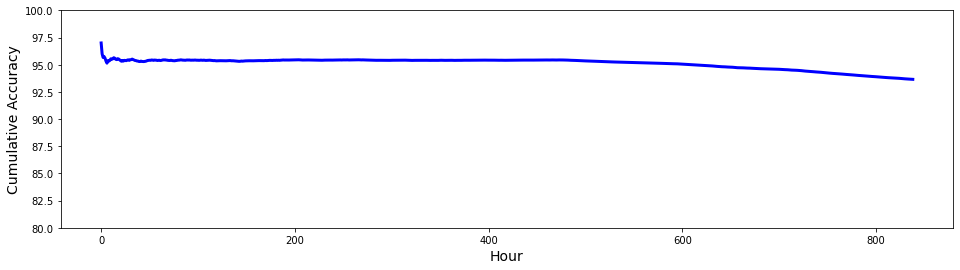

In [7]:
# plot the cumulative accuracy
plt.figure(figsize=(16,4))
plt.ylim([80, 100])
plt.plot(cumulative_accuracy[1:], color='blue', linewidth=3)
plt.ylabel('Cumulative Accuracy', fontsize=14)
plt.xlabel('Hour', fontsize=14)
plt.show()

### Sliding Window Accuracy

Another important consideration is to calculate metrics over a certain period of time, rather than an overall cumulative metric. For instance, in the next cells, a sliding window averaging is calculated for the accuracy over the last 24 hours. The value of the metric on the last day of available data is equal to 88.7% accuracy.  

In [8]:
# 24 hours window size 
window_size = 24

# sliding window accuracy
sliding_accuracy = np.convolve(hourly_accuracy, np.ones(window_size)/window_size, mode="valid")

# print average daily sliding window accuracy in the last 24 hours
print (f"Average sliding accuracy in the last 24 hours: {np.mean(sliding_accuracy[-24:]):.1f}")

Average sliding accuracy in the last 24 hours: 88.7


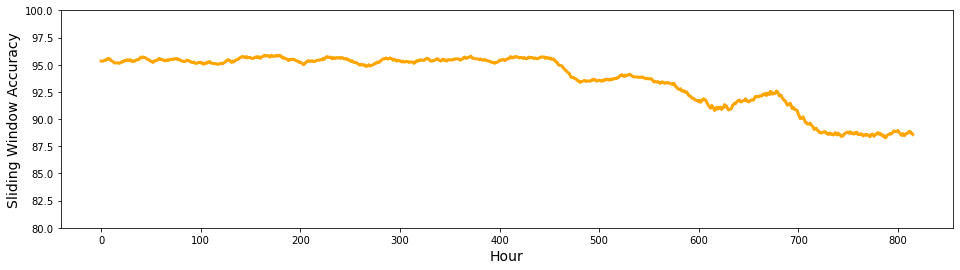

In [9]:
# plot the sliding window accuracy
plt.figure(figsize=(16,4))
plt.ylim([80, 100])
plt.plot(sliding_accuracy[1:], color='orange', linewidth=3)
plt.ylabel('Sliding Window Accuracy', fontsize=14)
plt.xlabel('Hour', fontsize=14)
plt.show()

### Combined Plots

A figure with combined plots for the metrics is shown below. It is assumed that the threshold under which the performance is unacceptable is 90% accuracy. It is noticeable from the figure that the sliding window metric allowed to catch the performance degradations at 90% accuracy earlier than the cumulative accuracy metric. This example demonstrates the need to using multiple metrics with different window sizes in order to identify decrease in performance as early as possible. 

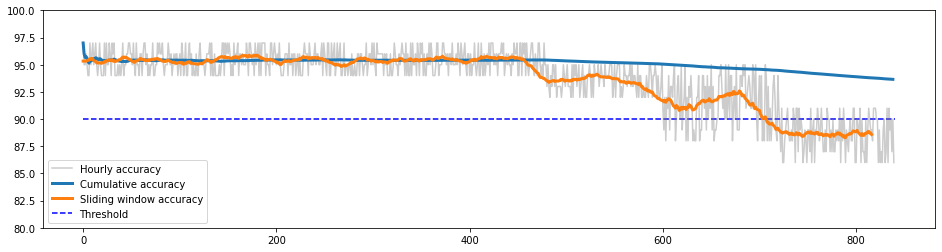

In [10]:
plt.figure(figsize=(16,4))
plt.ylim([80, 100])
plt.plot(hourly_accuracy, label="Hourly accuracy", color='gray', alpha=0.4)
plt.plot(cumulative_accuracy[1:], linewidth=3, label="Cumulative accuracy")
plt.plot(sliding_accuracy, linewidth=3, label="Sliding window accuracy")
plt.hlines(y=90, xmin=0, xmax=np.size(hourly_accuracy), colors="blue", linestyles="dashed", label="Threshold")
plt.legend()
plt.show()

<a name='section3'></a>

# 29.3 Data Validation

An important step in monitoring performance is to implement measures for ensuring that the collected data from production are in correct format, have the expected data types, do not have missing values, the values are in the expected ranges, etc. 

There are numerous tools that can be used for this purpose, and here we will present the [Great Expectations](https://github.com/great-expectations/great_expectations) library. 

To demonstrate the concept, we will use a dataset consisting of text regarding data science projects, and labels that predict the topic of the text. In the next cells, the dataset is loaded as a pandas dataframe, and the first few rows are shown. Next, data statistics are shown.

In [11]:
# load labeled projects
df = pd.read_csv('projects.csv')
df.head()

,text,label
0,Comparison between YOLO and RCNN on real world...,computer-vision
1,"Show, Infer & Tell: Contextual Inference for C...",computer-vision
2,Awesome Graph Classification A collection of i...,graph-learning
3,Awesome Monte Carlo Tree Search A curated list...,reinforcement-learning
4,Diffusion to Vector Reference implementation o...,graph-learning


In [12]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    955 non-null    object
 1   label   955 non-null    object
dtypes: object(2)
memory usage: 15.0+ KB


In [13]:
# classes in the label column
df['label'].value_counts()

natural-language-processing    388
computer-vision                356
mlops                           79
reinforcement-learning          56
graph-learning                  45
time-series                     31
Name: label, dtype: int64

We will next install the Great Expectations library. 

In [ ]:
!pip install great-expectations==0.15.7 -q

And, we will apply the library to the dataframe, which here is named `production_df`.

In [15]:
import great_expectations as ge

# convert using Great Expectations
production_df = ge.dataset.PandasDataset(df)

Let's apply two expectation rules about the data, which understandably is in the `text` column. Since we assume that this is production data, we won't have the information about the labels, as the model needs to predict the labels.

The two rules below are self-explanatory, and they will check whether the data are not null and the type of the data is string. 

In [ ]:
# define expectations
production_df.expect_column_values_to_not_be_null(column="text")
production_df.expect_column_values_to_be_of_type(column="text", type_="str")

Afterward, we will create an `expectation_suite` which will combine all expectations. Finally, the production data is validated, and as we can see, both expectations passed, meaning that all rows in the `text` column are not null and have string type.

In [17]:
# create an expectation suite
expectation_suite = production_df.get_expectation_suite()

In [18]:
# validate production data
production_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 2,
 'unsuccessful_expectations': 0,
 'success_percent': 100.0}

Let's assume that we have new production data shown in the next cell that is fed to the model. The dataset intentionally has two rows with numeric data, instead of string data. 

When the expectation suite is used to validate the `simulated_df` dataframe, the expectation `expect_column_values_to_be_of_type 'str'` was unsuccessful. 

In [19]:
# simulated new production data
simulated_df = pd.DataFrame(["Hello world", 100, "This is the third sentence", 459, "Data Science"], columns=['text'])
simulated_df

,text
0,Hello world
1,100
2,This is the third sentence
3,459
4,Data Science


In [20]:
# convert using Great Expectations
simulated_df = ge.dataset.PandasDataset(simulated_df)

In [21]:
# validate simulated data
simulated_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 1,
 'unsuccessful_expectations': 1,
 'success_percent': 50.0}

Great expectations allows to easily apply many other rules, such as the following.

```
expect_column_to_exist()

expect_column_values_to_be_unique()

expect_table_row_count_to_be_between()

expect_table_columns_to_match_ordered_list(column_list=["id", "created_on", "title", "description", "tag"])

expect_column_values_to_be_in_set(column="label", value_set=["computer-vision", "graph-learning", "reinforcement-learning", "natural-language-processing", "mlops", "time-series"])
```

Such rule-based validation of production data is typically performed as an initial validation step, and it is followed by a quantitative validation to ensure that a data drift does not affect the performance.

<a name='section4'></a>

# 29.4 Data Distribution Shift

Data distribution shift, or drift, occurs when the process that produces the input data and labels in production differs from the process that generated the training input data and labels. 

In the lecture on DSOps, we mentioned that the main reasons for degradation in model performance are:
- **Data drift**, when the distribution of production data that is fed to a deployed model is different than the distribution of the data on which the model was trained. This type of drift is also called *feature drift* or *covariate shift*. If we denote the training data as $X_{ref}$ and the production data as $X_{prod}$, then the data drift means that $P(X_{prod}) \neq P(X_{ref})$. The model is trained under the assumption that the production data is identically distributed as the training data, and in the case of data drift, the predictions by the model become unreliable. There can be several different reasons for the occurrence of data drift, such as a bug in the data pipeline, launch of the model in new country, data collected from users from different demographic groups, or even malicious users feeding the model bad data.
- **Concept drift**, also known as *posterior shift*, when the relationship between the data and the output of the deployed model has changed. If we denote the output of the model with $y$, concept drift means that $P(y|X_{prod}) \neq P(y|X_{ref})$. An example of concept drift is when the users' behavior changes, and the trained model that was used to predict the users' behavior based on train data can not produce anymore valid predictions. Or, a model is trained to predict housing prices before COVID, and the changes during COVID impacted the relationship between input data and model outputs. And one more example is the difference in service prices over weekends, where one model can be used for weekdays and another model used for weekends. 
- **Target drift**, or *label drift*, when the distribution of the outputs of the model in production is changed in comparison to the trained model. That is, $P(y_{prod}) \neq P(y_{ref})$. For example, occurrences of new class labels in the production data that were not present in the train date, or changes in the data schemas (e.g., renamed columns) can cause target drift. This type of drift can be avoided by having adequate communication between the teams regarding the output classes, data schemas, etc. 
- **Domain shift**, when the data distribution is not sampled adequately. For instance, improper sampling that contains biases in the sampled function can result in biased predictions by the trained model. Or, occurrence of many outliers in production data that were not present in the training data will also result in performance degradation.

To measure drift, it is important to identify a set of *reference data points* that reflect the distribution of the training data. Then, for a new set of *test data points*, the distribution will be compared to the reference data to calculate drift. For selecting the reference and test data points, either a fixed or sliding window over the data can be used. Sliding windows with different length of the windows are often preferred with production data, to ensure that the changes in the data distribution are caught as early as possible. 

Measuring drift is typically achieved by applying *statistical two-sample hypothesis testing* techniques, that compare the distribution of the reference and test data points, and calculate statistics to infer whether there is a statistically significant difference between the distributions. 




<a name='section4-1'></a>

## 29.4.1 Measuring Drift in Univariate Numerical Data

Univariate data consist of single feature (variable) that changes over time. If the data is numerical, measuring drift is often performed by applying the **Kolmogorov-Smirnov (KS) test**. The KS test compares two samples, and quantifies the distance between the distributions of the samples.

Let's assume that we would like to monitor the number of words in the incoming data for the same example from above. If the number of words in input text is too low or too high, that may indicate a data drift. 

The code in the next cell adds a new column to the dataframe, which contains the number of words in each row. 

In [22]:
# calculate the number of words in the column 'text'
production_df["num_tokens"] = production_df['text'].str.split().str.len()
production_df.head()

,text,label,num_tokens
0,Comparison between YOLO and RCNN on real world...,computer-vision,28
1,"Show, Infer & Tell: Contextual Inference for C...",computer-vision,36
2,Awesome Graph Classification A collection of i...,graph-learning,16
3,Awesome Monte Carlo Tree Search A curated list...,reinforcement-learning,16
4,Diffusion to Vector Reference implementation o...,graph-learning,14


And, let's take the first 200 rows in the dataframe to be the reference data for measuring the drift. The distribution of the number of words is shown in the histogram below, where we can see that the rows in the `text` column have about 20 words on average.

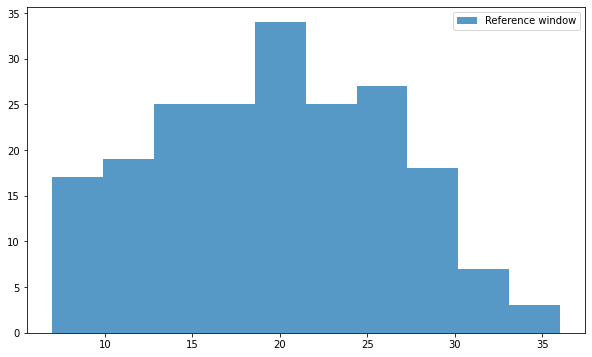

In [23]:
# take the first 200 records as reference
plt.figure(figsize=(10,6))
reference_data = production_df["num_tokens"][0:200].to_numpy()
plt.hist(reference_data, alpha=0.75, bins=10, label="Reference window")
plt.legend()
plt.show()

Let's take the rows from 200 to 400 in the dataframe to be test data for measuring the drift. Since the data is from the same distribution, we don't expect to see drift for this case. In real-world cases, this will be production data, and the reference data will consist of representative examples from the training data. 

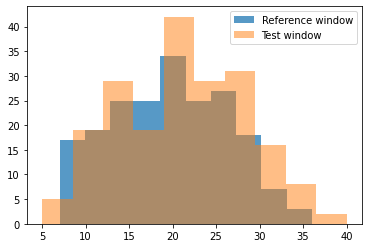

In [24]:
# use the observations 200 to 400 as new production data (does not have drift)
test_data = production_df["num_tokens"][200:400].to_numpy()
plt.hist(reference_data, alpha=0.75, label="Reference window")
plt.hist(test_data, alpha=0.5, label="Test window")
plt.legend()
plt.show()

To measure data drift we will use the [Alibi Detect](https://docs.seldon.io/projects/alibi-detect/en/latest/) library, which provides various useful functions for drift detection, such as the `KSDrift` that applies the Kolmogorov-Smirnov test. 

In [25]:
# install Alibi Detect
!pip install -q alibi-detect==0.9.1 

     |████████████████████████████████| 246 kB 5.0 MB/s 
     |████████████████████████████████| 498.0 MB 10 kB/s 
     |████████████████████████████████| 3.4 MB 95.1 MB/s 
     |████████████████████████████████| 4.8 MB 80.9 MB/s 
     |████████████████████████████████| 5.8 MB 96.1 MB/s 
     |████████████████████████████████| 34.5 MB 1.4 MB/s 
     |████████████████████████████████| 1.4 MB 93.4 MB/s 
     |████████████████████████████████| 462 kB 86.0 MB/s 
     |████████████████████████████████| 5.8 MB 92.4 MB/s 
     |████████████████████████████████| 7.6 MB 94.5 MB/s 
     |████████████████████████████████| 182 kB 93.9 MB/s 


In [26]:
from alibi_detect.cd import KSDrift

/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/internal/backend/numpy/dtype.py:82: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = np.bool  # pylint: disable=redefined-builtin
/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/internal/backend/numpy/dtype.py:112: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

The KSDrift function is first applied to the `reference data`, similarly to fitting a model to data, and afterward it is used to predict the drift of `test data`. The most important parameter from the test is the `p-value`, which indicates whether the hypothesis that the two distributions are the same can be rejected. If the p-value is smaller than the set significance threshold value of 0.01, then the hypothesis can be rejected. In this case, the p-value is 0.3, that is, the hypothesis cannot be rejected, the two distributions are the same, and there is no drift in the test data.

In [27]:
# initialize drift detector
length_drift_detector = KSDrift(reference_data, p_val=0.01)

In [28]:
# calculate drift for the test window data
length_drift_detector.predict(test_data, return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': array([0.095], dtype=float32),
  'p_val': array([0.30775842], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1'}}

To illustrate the opposite case, in the next cell simulated data is created that have different distribution than the reference data, with an average number of words about 30 per text entry. The KSDrift test for this data resulted in a p-value of almost 0, which indicates drift in the test data, as expected. 

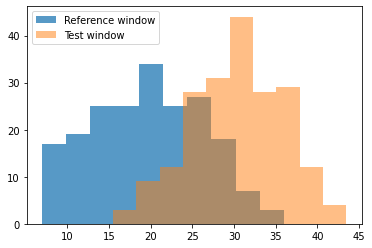

In [29]:
# create simulated drift data from a random normal distribution
drift_data = np.random.normal(30, 5, len(reference_data))

plt.hist(reference_data, alpha=0.75, label="Reference window")
plt.hist(drift_data, alpha=0.5, label="Test window")
plt.legend()
plt.show()

In [30]:
# calculate drift for the test window data
length_drift_detector.predict(drift_data, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([0.605], dtype=float32),
  'p_val': array([1.3373137e-35], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1'}}

<a name='section4-2'></a>

## 29.4.2 Measuring Drift in Univariate Categorical Data

If the data is categorical, data drift can be measured by using the **Chi-squared test**. This test is also suitable for measuring target drift in classification tasks, where the target is commonly a categorical variable with multiple classes.

Let's create a new categorical variable for the number of words in the `text` column, where if the word count is less than 10 the data are assigned to the `small` category, if less than 25 words the `medium` category is assigned, and for rows with more than 25 words the category is `large`.

In [31]:
# classify text based on number of tokens
production_df['token_count'] = production_df.num_tokens.apply(lambda x: "small" if x <= 10 else ("medium" if x <=25 else "large"))
production_df.head(10)

,text,label,num_tokens,token_count
0,Comparison between YOLO and RCNN on real world...,computer-vision,28,large
1,"Show, Infer & Tell: Contextual Inference for C...",computer-vision,36,large
2,Awesome Graph Classification A collection of i...,graph-learning,16,medium
3,Awesome Monte Carlo Tree Search A curated list...,reinforcement-learning,16,medium
4,Diffusion to Vector Reference implementation o...,graph-learning,14,medium
5,"AttentionWalk A PyTorch Implementation of ""Wat...",graph-learning,16,medium
6,Graph Wavelet Neural Network A PyTorch impleme...,graph-learning,14,medium
7,"APPNP and PPNP A PyTorch implementation of ""Pr...",graph-learning,18,medium
8,Attributed Social Network Embedding A sparsity...,graph-learning,18,medium
9,Signed Graph Convolutional Network A PyTorch i...,graph-learning,14,medium


The distributions of the `reference data` and `test data` per category are shown below. 

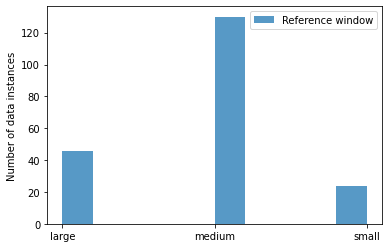

In [32]:
# use the firt 200 data points as reference data 
reference_data = production_df['token_count'][0:200].to_numpy()
plt.hist(reference_data, alpha=0.75, label="Reference window")
plt.ylabel('Number of data instances')
plt.legend()
plt.show()

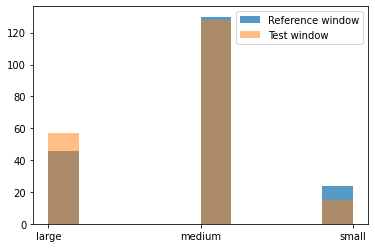

In [33]:
# use the data points from 200 to 400 as new production data (does not have drift)
test_data = df['token_count'][200:400].to_numpy()
plt.hist(reference_data, alpha=0.75, label="Reference window")
plt.hist(test_data , alpha=0.5, label="Test window")
plt.legend()
plt.show()

Similarly to the previous example, we will import the `ChiSquareDrift` function, will apply it first to the `reference data`, and afterward will use it to predict the drift of the `test data`. The obtained p-value is 0.19, that is, there is no drift in the test data. 

In [34]:
from alibi_detect.cd import ChiSquareDrift

In [35]:
# initialize drift detector
categorical_drift_detector = ChiSquareDrift(reference_data, p_val=0.01)

In [36]:
# calculate drift for the test window data
categorical_drift_detector.predict(test_data, return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': array([3.2671843], dtype=float32),
  'p_val': array([0.19522704], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1'}}

One more example is considered, where the data is intentionally set to be different from the reference data. The ChiSquare test results in very small p-value, which is indicative of drift.

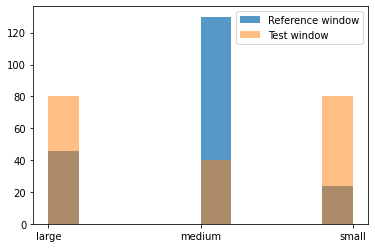

In [37]:
# simulated drift data
drift_data = np.array(["small"]*80 + ["medium"]*40 + ["large"]*80)
plt.hist(reference_data, alpha=0.75, label="Reference window")
plt.hist(drift_data, alpha=0.5, label="Test window")
plt.legend()
plt.show()

In [38]:
# calculate drift for the test window data
categorical_drift_detector.predict(drift_data, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([86.97551], dtype=float32),
  'p_val': array([1.2986986e-19], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1'}}

<a name='section4-3'></a>

## 29.4.3 Measuring Drift in Multivariate Data

*Multivariate data* are data with multiple dependent variables, that is, multidimensional data. Measuring drift in multivariate inputs is more challenging, in comparison to univariate inputs. 

We will consider again the previous example, and let's assume that a transformer NLP model was used for classifying the inputs in the `text`  column into the categories listed in the `label` column. As we know, each text input will need to be first tokenized and then converted into numerical embedding vector, which will be fed into the model. The text embeddings are multidimensional vectors, and as we will see, for this case, the embeddings have 768 dimensions. The question that we would like to answer is how to identify drift in the multivariate input text data that is fed to this model when deployed in production.

In [39]:
df.head()

,text,label,num_tokens,token_count
0,Comparison between YOLO and RCNN on real world...,computer-vision,28,large
1,"Show, Infer & Tell: Contextual Inference for C...",computer-vision,36,large
2,Awesome Graph Classification A collection of i...,graph-learning,16,medium
3,Awesome Monte Carlo Tree Search A curated list...,reinforcement-learning,16,medium
4,Diffusion to Vector Reference implementation o...,graph-learning,14,medium


Let's consider that the following pretrained version of BERT `scibert_scivocab_uncased` was used for assigning class labels to the above text inputs. And, let's retrieve the corresponding tokenizer that is used with this model, so that we can apply it to the text data.

In [40]:
from transformers import AutoTokenizer

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [41]:
# display the vocabulary size of the tokenizer for the model
vocab_size = len(tokenizer)
print ('Vocabulary size:', vocab_size)

Vocabulary size: 31090


As the reference data, we will again consider the first 200 rows in the dataframe. The next cell tokenizes the data and applies padding. 

In [42]:
# reference data
reference_data = df['text'][0:200].to_list()

# tokenize inputs
encoded_input = tokenizer(reference_data, return_tensors="pt", padding=True)

As a sanity check, let's display the tokenized first text entry, and convert it back to text to ensure that the tokenization worked as expected.

In [43]:
# check the tokens for the first sentence
encoded_input['input_ids'][0]

tensor([  102,  2029,   467,  1778,   609,   137,  6446,  4857,   191,  1332,
         2399, 13572, 19125,  1983,   147,  1954,   165,  6240,   205,   185,
          300,  3717,  7434,  1262,   121,   537,   201,   137,  1040,   111,
          545,   121,  4714,   205,   103,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])

In [44]:
# convert to words
print (tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0]))

['[CLS]', 'comparison', 'between', 'yo', '##lo', 'and', 'rc', '##nn', 'on', 'real', 'world', 'videos', 'bringing', 'theory', 'to', 'experiment', 'is', 'cool', '.', 'we', 'can', 'easily', 'train', 'models', 'in', 'col', '##ab', 'and', 'find', 'the', 'results', 'in', 'minutes', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [45]:
# compare to the actual text
df['text'][0]

'Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.'

Next, we will extract the outputs of the embedding layer in the model. The outputs of the embedding layer are 768-dimensional vectors for each text input. For this model, we know that the embedding layer is followed by 8 other layers, so we will use this information to obtain the outputs of the embedding layer.


In [46]:
from alibi_detect.models.pytorch import TransformerEmbedding

In [47]:
 # get the last 8 layers
layers = [-x for x in range(1, 9)] 
# embedding layer
embedding_layer = TransformerEmbedding(model_name, "hidden_state", layers)

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
# embedding dimension
print(embedding_layer.model.embeddings.word_embeddings.embedding_dim)

768


### Dimensionality reduction

When the dimensionality of input data is very high (as in this case where the inputs are 768-dimensional vectors), performing statistical hypothesis testing is computationally very expensive, and dimensionality reduction techniques are often applied to first reduce the dimensionality and afterward measure drift using lower-dimensional data. We previously described Principal Component Analysis (PCA) as a commonly used technique for dimensionality reduction and for feature engineering. Another technique includes autoencoder (AE) neural network, and we will use this technique to reduce the dimensionality of the text embeddings from 768 dimensions to 32 dimensions.



In [49]:
import torch
import torch.nn as nn

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The autoencoder model is shown below and it is named `dim_reduce_model`. It is a simple neural network that takes inputs of size 768, and uses 2 dense layers to reduce it to outputs of size 32.

In [50]:
# dimensionality reduction with an autoencoder (AE) model
dim_reduce_model = nn.Sequential(
    embedding_layer,
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 32)
).to(device).eval()

We can now define a preprocessing function, which takes input text, tokenizes it, retrieves the 768-dimensional embedding, and outputs a 32-dimensional vector. 

In [51]:
from alibi_detect.cd.pytorch import preprocess_drift
from functools import partial

# preprocessing with the autoencoder model
preprocess_fn = partial(preprocess_drift, model=dim_reduce_model, tokenizer=tokenizer,
                        max_len=100, batch_size=32, device=device)

### Statistical Hypothesis Testing

There are several different statistical tests that can be applied to multivariate data. A popular choice is the **Maximum Mean Discrepancy** (MMD) test, that calculates the distance between the mean embeddings from two distributions. 

To apply the test, we will import the function `MMDDrift`, and we can again use rows 200 to 400 from the dataframe as `test data` to calculate the drift. As expected, the p-value is greater than the set threshold of 0.01, meaning that there is no drift in the test data.


In [52]:
from alibi_detect.cd import MMDDrift

In [53]:
# initialize MMD drift detector
mmd_drift_detector = MMDDrift(reference_data, backend="pytorch", p_val=.01, preprocess_fn=preprocess_fn)

In [54]:
# test data with no drift, based on rows 200 to 400 from the dataframe 
test_data = df['text'][200:400].to_list()
mmd_drift_detector.predict(test_data)

{'data': {'is_drift': 1,
  'distance': 0.003041207790374756,
  'p_val': 0.009999999776482582,
  'threshold': 0.01,
  'distance_threshold': 0.0024504066},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1',
  'backend': 'pytorch'}}

We will also create new data by adding two unknown words (UNK) to each instance in the text data. This data is expected to have drift, because of the presence of the unknown words. The obtained p-value below confirms this assumption.

In [55]:
# create new data by adding two "UNK" (unknown) words to all text data
drift_data = ["UNK UNK " + text for text in test_data]
# first 5 data instances
drift_data[:5]

['UNK UNK Torchvision Object Detection Finetuning Tutorial Finetuning a pre-trained Mask R-CNN model in the Penn-Fudan Database for Pedestrian Detection and Segmentation.',
 'UNK UNK Deep Learning for Videos: A 2018 Guide to Action Recognition In this post, I summarize the literature on action recognition from videos. ',
 "UNK UNK Shakespeare Meets Google's Flax Application of RNNs in Flax: Character-Level Language Model.",
 'UNK UNK Anomaly detection with Keras, TensorFlow, and Deep Learning Perform anomaly detection in your own image datasets using deep learning.',
 'UNK UNK Almost Everything You Need to Know About Time Series Understand moving average, exponential smoothing, stationarity, autocorrelation, SARIMA, and more.']

In [56]:
# calculate drift for the test window data
mmd_drift_detector.predict(drift_data)

{'data': {'is_drift': 1,
  'distance': 0.04228019714355469,
  'p_val': 0.0,
  'threshold': 0.01,
  'distance_threshold': 0.002794683},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1',
  'backend': 'pytorch'}}

<a name='section5'></a>

# 29.5 Monitoring Drift in Online Data

In a real-world scenario, measuring drift is performed with online data. This requires to select the adequate window size, p-value, and other parameters, for data that is from unknown distribution. As we mentioned before, there are various trade-offs in selecting these parameters, e.g., a small window size can catch drift more quickly, but may miss a long-term gradual drift. 

One approach is to measure drift using windows of different sizes, and compare the results. The code below applies an MMD drift detector for online data. As reference data, we selected the text inputs for the first 800 columns in the dataframe. 


In [57]:
from alibi_detect.cd import MMDDriftOnline

In [58]:
# Online MMD drift detector
reference_data = df['text'][0:800].to_list()
online_mmd_drift_detector = MMDDriftOnline(reference_data, ert=400, window_size=200, backend="pytorch", preprocess_fn=preprocess_fn)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 200/200 [00:35<00:00,  5.63it/s]


Now we can define a `simulate_production` function that applies the above drift detector repeatedly to each new data point, and increases the window size by 1 until drift is detected.

In [59]:
def simulate_production(test_window):
    i = 1
    online_mmd_drift_detector.reset()
    for text in test_window:
        result = online_mmd_drift_detector.predict(text)
        is_drift = result["data"]["is_drift"]
        if is_drift:
            break
        else:
            i += 1
    print (f"window size: {i} data points")

To evaluate the performance of the drift detector, let's first use rows from 800 until 954 in the dataframe as simulated data. As we can see below, the window size for which drift was detected was 25 data points.

In [64]:
# Normal
test_normal_window = production_df.text[800:]
simulate_production(test_normal_window)

window size: 21 data points


In [61]:
test_normal_window

800    Test-Time Data Augmentation Tutorial on how to...
801    SadedeGel: An extraction based Turkish news su...
802    MobyDick word frequency Getting the count of t...
803    Image Classification with Keras Build a pipeli...
804    Dropout in PyTorch – An Example An example of ...
                             ...                        
950    A Survey of the State of Explainable AI for NL...
951    Topic Modeling with BERT Leveraging 🤗 Transfor...
952    OpenMMLab Computer Vision MMCV is a python lib...
953    Machine Learning Methods Explained (+ Examples...
954    Rasoee A powerful web and mobile application t...
Name: text, Length: 155, dtype: object

And let's consider one more example which consists of the unknown token word `'UNK'` repeated many times. For this case, the drift detector identified drift after 10 data points. 

In [62]:
# Drift
test_drift_window = "UNK" * 100
simulate_production(test_drift_window)

window size: 12 data points


In [63]:
test_drift_window

'UNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNK'

Conclusively, using windows with different size is beneficial for catching data drift sooner. 

<a name='section6'></a>

# 29.6 Data Outliers

Differently from drift that is used for identifying changes in the data distribution based on a window of data points, **outliers** are individual data points that are outside of the range of the data distribution. Detecting outliers is often challenging, because it requires to define criteria for assigning a data point as outlier. This problem can be considered as anomaly detection, and various developed approaches for anomaly detection can be applied. These approaches typically solve an unsupervised learning problem, where the goal is to first learn the distribution of normal data, and then use a threshold to detect outliers in the distribution. 

<a name='section7'></a>

# 29.7 Taking Actions

Once data distribution shifts are detected, the next step involves identifying the root causes for it, to prevent the issue from reoccurring. 
Actions can involve retraining the model using new data with shifted distribution, ensure that data processing pipelines are correctly set and are updated, adopt new reference data for validating the data drift, and similar.

There are several tools that have been developed for monitoring system performance, such as WhyLabs, TorchDrift, EvidentlyAI, Arize, as well as the platforms that are designed for deploying ML models, such as SageMaker, TorchServe, offer tools for monitoring the performance of deployed models. 

<a name='section8'></a>

# References

1. Made with ML, Monitoring Machine Learning Systems, by Goku Mohandas, available at [https://madewithml.com/courses/mlops/monitoring/](https://madewithml.com/courses/mlops/monitoring/).
2. Designing Machine Learning Systems, by Chip Huyen, O'Reilly Media, 2022.
3. Drift Detection, Alibi Detect, available at: [https://docs.seldon.io/projects/alibi-detect/en/latest/cd/background.html#what-is-drift](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/background.html#what-is-drift).

[BACK TO TOP](#section0)